## Classification model with DistilBert Embeddings 

This model is fine tuned on Distilbert Architecture 

##### *Loading packages and Libraries*

In [1]:
#!pip install transformers

In [2]:
#!pip install codecarbon

In [3]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import json
import os 
import xlrd

from codecarbon import EmissionsTracker

#### *Reading the data*

Here we are loading the data from shared drive

In [4]:
!pip install -U -q PyDrive

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# link to the shared folder for the dataset
link = 'https://docs.google.com/spreadsheets/d/1q9-QbBWLGKxnNvKkkO6SDKtOFo-PD3Di/edit?usp=sharing&ouid=114681321378295576593&rtpof=true&sd=true' 
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('annotations.xlsx')  # MBAD data
  
df = pd.read_excel('annotations.xlsx')
print(df)

       Unnamed: 0  Unnamed: 0.1  ...   news_check_frequency survey_completed
0               0         19227  ...              Every day             True
1               1         19228  ...              Every day             True
2               2         19229  ...              Every day             True
3               3         19231  ...              Every day             True
4               4         19232  ...              Every day             True
...           ...           ...  ...                    ...              ...
17770       22466         18746  ...  Several times per day             True
17771       22467         18748  ...  Several times per day             True
17772       22468         18749  ...  Several times per day             True
17773       22469         18753  ...  Several times per day             True
17774       22470         18755  ...  Several times per day             True

[17775 rows x 24 columns]


In [7]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'survey_record_id', 'sentence_id',
       'sentence_group_id', 'created_at', 'label', 'words', 'factual',
       'group_id', 'text', 'link', 'type', 'topic', 'outlet', 'mturk_id',
       'age', 'gender', 'education', 'native_english_speaker',
       'political_ideology', 'followed_news_outlets', 'news_check_frequency',
       'survey_completed'],
      dtype='object')

#### *Data Manipulation*

In [8]:
# filtering required columns
df = df[['label', 'words', 'factual', 'text', 'topic']]
df = df.dropna(subset=['text', 'label'])
df.head()

,label,words,factual,text,topic
0,Non-biased,NaN,Entirely factual,The transgender effort to suppress any recogni...,gender
1,Non-biased,NaN,Expresses writer’s opinion,Radical Virginia Citizens Defense League has o...,gun-control
2,Non-biased,NaN,Somewhat factual but also opinionated,Miller is the architect of President Donald Tr...,white-nationalism
3,Non-biased,NaN,Expresses writer’s opinion,"The House Democrats’ 1,400-page coronavirus re...",coronavirus
4,Non-biased,NaN,Expresses writer’s opinion,A specter is haunting the West; our elites see...,white-nationalism


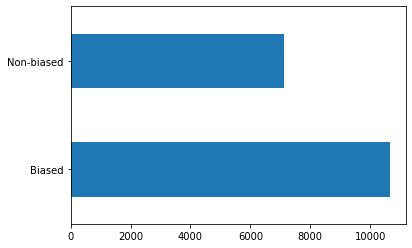

In [9]:
df['label'].value_counts().plot(kind='barh')

In [10]:
df['encoded Label'] = df['label']
df.replace({'encoded Label': {'Non-biased': 0, 'Biased': 1}}, inplace=True)

#### *Features and Labels*

In [11]:
data_texts = df["text"].to_list() # Features (not-tokenized yet)
data_labels = df["encoded Label"].to_list() # Lables

#### *Splitting data to train and test*

In [12]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.10, random_state=0)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.10, random_state=0)

#### *tokenizing the text*

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cuda = 0)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

#### *Datset object for Tensorflow*

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

#### *Model definition*

In [15]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [16]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


#### *Traning the Model*

In [ ]:
tracker = EmissionsTracker()
tracker.start()

history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=30, batch_size=16,
                    validation_data=val_dataset.shuffle(1000).batch(16))

tracker.stop()

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
/usr/local/lib/python3.7/dist-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':
/usr/local/lib/python3.7/dist-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)


Epoch 1/30
900/900 [==============================] - 378s 420ms/step - loss: 0.6161 - accuracy: 0.6648 - val_loss: 0.6153 - val_accuracy: 0.6749
Epoch 2/30
900/900 [==============================] - 376s 418ms/step - loss: 0.5737 - accuracy: 0.7048 - val_loss: 0.6232 - val_accuracy: 0.6654
Epoch 3/30
900/900 [==============================] - 376s 418ms/step - loss: 0.5506 - accuracy: 0.7189 - val_loss: 0.6962 - val_accuracy: 0.6597
Epoch 4/30
164/900 [====>.........................] - ETA: 4:54 - loss: 0.5123 - accuracy: 0.7424

#### *Save the Model in working directory*


In [ ]:
save_directory = '.\model'

In [ ]:
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


#### *Loading the Model*

In [ ]:
save_directory = '.\model'

In [ ]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

#### *Testing on Custom Data*

In [ ]:
def prediction(test_text):
    predict_input = loaded_tokenizer.encode(test_text,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    
    if (prediction_value == 1):
        label = "Biased"
    else (prediction_value == 0):
        label = 'Non-biased'
    
    return label

In [ ]:
test_text = ""
prediction(test_text)

In [ ]:
'Non-biased': 0, 'Biased': 1